In [ ]:
# 1. Install Necessary Libraries
# Connecting to BigQuery from Google Colab and pulling data is a straightforward process, primarily involving authentication and using the google-cloud-bigquery library.
# First, we'll need the google-cloud-bigquery library to interact with BigQuery and pandas to work with the data in a DataFrame.
# !pip install google-cloud-bigquery pandas

# 2. Authenticate Your Colab Environment
# Google Colab provides a simple way to authenticate using your Google account. This is the most common method for interactive use in Colab

from google.colab import auth
auth.authenticate_user()
print('Authenticated')

In [6]:
# All Imports
from google.cloud import bigquery
from google.colab import auth
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import spacy
import re
import string
from collections import Counter

import numpy as np

from spacy.pipeline import EntityRuler
from spacy.tokens import DocBin


In [7]:
# Connect Google Cloud Project ID
# We need to use the BigQuery client which Google Cloud Project your data resides in.
project_id = 'quantum-vigil-417213' # Replace with your actual Google Cloud Project ID

In [8]:
# Authenticate Your Colab Environment
# Google Colab provides a simple way to authenticate using your Google account. This is the most common method for interactive use in Colab
# following block is commeneted here because we're conssollidating all imports in one place which will be shown later.
# from google.colab import auth

auth.authenticate_user()
print('Authenticated')

Authenticated


In [9]:
# Initialize the BigQuery Client
# Create an instance of the BigQuery client. This object will manage your connection and allow you to send queries.
#  following block is commeneted here because we're conssollidating all imports in one place which will be shown later.
# from google.cloud import bigquery

client = bigquery.Client(project=project_id)
print('BigQuery client initialized.')

BigQuery client initialized.


In [10]:
# Write Your SQL Query
# Craft your SQL query. Remember to specify the full path for your tables using the format resources.dataset_name.table_name.
# This Counts of patients who died within 7 days of hospital admission by marital status and age at death
query = """
SELECT
  a.marital_status,
  COUNT(*) AS death_count,
  ROUND(AVG(DATE_DIFF(p.dod, p.dob, YEAR)), 1) AS avg_age_at_death
FROM
  physionet-data.mimiciii_demo.patients AS p
JOIN
  physionet-data.mimiciii_demo.admissions a
  ON p.subject_id = a.subject_id
WHERE
  p.dod IS NOT NULL
  AND a.admittime IS NOT NULL
  --AND p.dod <= DATE_ADD(a.admittime, INTERVAL 7 DAY)
GROUP BY
  a.marital_status
ORDER BY
  avg_age_at_death DESC;
"""
print('SQL query defined.')

SQL query defined.


In [11]:
# Execute the SQL to retrieve data set
# import pandas as pd
def run_bq_query(query):
  try:
      df_bigquery_data = client.query(query).to_dataframe()
      print('\nQuery executed successfully! Data loaded into pandas DataFrame.')
      print('First 5 rows of the data:')
      print(df_bigquery_data.head())
      return df_bigquery_data
  except Exception as e:
      print(f"\nAn error occurred: {e}")
      print("Please double-check:")
      print("  - Your `project_id` is correct.")
      print("  - The table names in your SQL query are fully qualified")
      print("  - Your Google account has the necessary BigQuery permissions")
      print("  - The BigQuery API is enabled for your Google Cloud Project.")

In [12]:
# Execute the cleaned SQL to retrieve data set
# import pandas as pd

df_bigquery_data = run_bq_query(query)


Query executed successfully! Data loaded into pandas DataFrame.
First 5 rows of the data:
      marital_status  death_count  avg_age_at_death
0               None           16             122.4
1            WIDOWED           15              97.7
2            MARRIED           60              81.9
3  UNKNOWN (DEFAULT)            5              79.6
4           DIVORCED            6              76.5


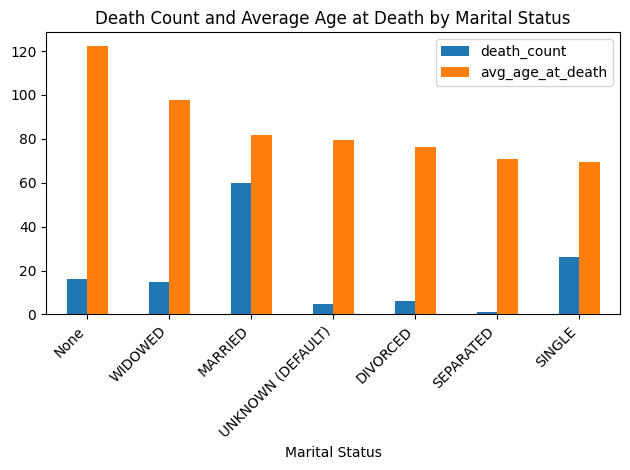

In [13]:
# Death Count by Marital Status ​(Bar Plot)​
# import matplotlib.pyplot as plt

ax = df_bigquery_data.plot.bar(x='marital_status', y=['death_count', 'avg_age_at_death'])
plt.title('Death Count and Average Age at Death by Marital Status')
plt.xlabel('Marital Status')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [14]:
# SQL query for your analysis, incorporating data cleaning steps
query_cleaned = """
SELECT
  CASE
    WHEN a.marital_status IS NULL
         OR a.marital_status IN ('UNKNOWN (DEFAULT)', 'None', '')
      THEN 'Unknown'
    ELSE a.marital_status
  END AS marital_status_cleaned,
  COUNT(*) AS death_count,
  ROUND(AVG(DATE_DIFF(p.dod, p.dob, YEAR)), 1) AS avg_age_at_death
FROM
  physionet-data.mimiciii_demo.patients AS p
JOIN
  physionet-data.mimiciii_demo.admissions AS a
  ON p.subject_id = a.subject_id
WHERE
  p.dod IS NOT NULL
  AND a.admittime IS NOT NULL
  AND DATE_DIFF(p.dod, p.dob, YEAR) BETWEEN 0 AND 110
  -- Uncomment the next line to restrict to deaths within 7 days of admission to check earli mortality after admission
  -- AND p.dod <= DATE_ADD(a.admittime, INTERVAL 7 DAY)
GROUP BY
  marital_status_cleaned
ORDER BY
  avg_age_at_death DESC;
"""
print('SQL query defined.')


SQL query defined.


In [15]:
# Execute the cleaned SQL to retrieve data set
# import pandas as pd

marital_counts_cleaned = run_bq_query(query_cleaned)


Query executed successfully! Data loaded into pandas DataFrame.
First 5 rows of the data:
  marital_status_cleaned  death_count  avg_age_at_death
0                WIDOWED           14              83.2
1               DIVORCED            6              76.5
2              SEPARATED            1              71.0
3                MARRIED           57              70.4
4                Unknown           17              68.0


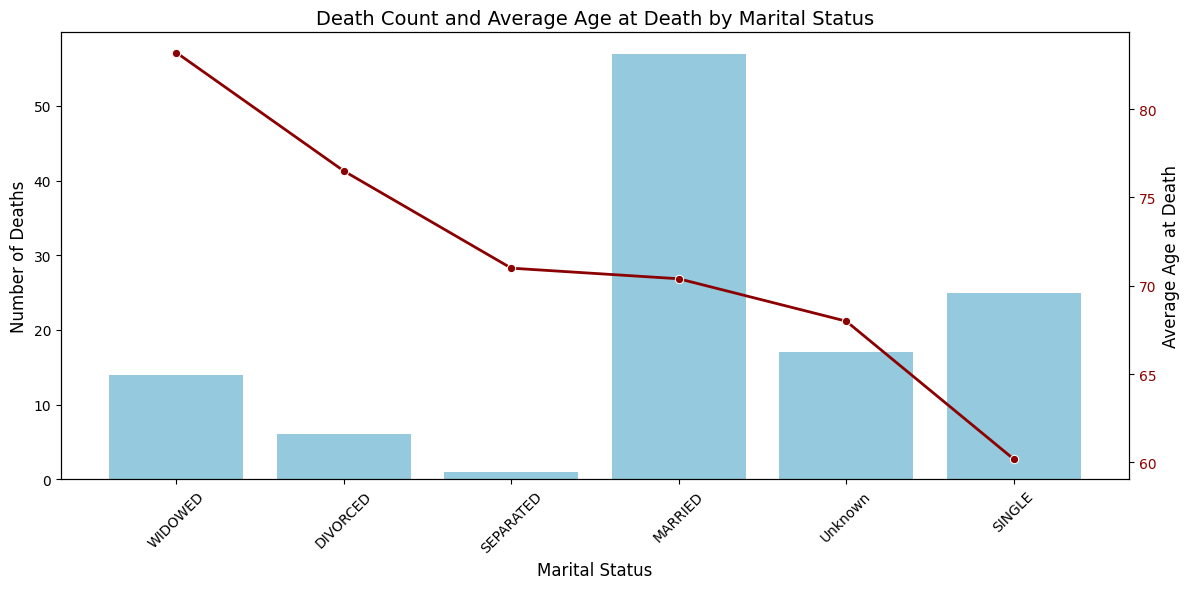

In [16]:
# Combined Bar + Line Plot: Death Count and Average Age at Death
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for death count
sns.barplot(
    x='marital_status_cleaned',
    y='death_count',
    data=marital_counts_cleaned,
    ax=ax1,
    color='skyblue'
)
ax1.set_ylabel('Number of Deaths', fontsize=12)
ax1.set_xlabel('Marital Status', fontsize=12)
ax1.set_title('Death Count and Average Age at Death by Marital Status', fontsize=14)
ax1.tick_params(axis='y')
plt.setp(ax1.get_xticklabels(), rotation=45)

# Line plot for average age at death on secondary y-axis
ax2 = ax1.twinx()
sns.lineplot(
    x='marital_status_cleaned',
    y='avg_age_at_death',
    data=marital_counts_cleaned,
    ax=ax2,
    color='darkred',
    marker='o',
    linewidth=2
)
ax2.set_ylabel('Average Age at Death', fontsize=12)
ax2.tick_params(axis='y', labelcolor='darkred')

# Show plot
plt.tight_layout()
plt.show()


In [21]:
# Restrict to deaths within 7 days of admission to check early mortality after admission

query_early_mortality = """
SELECT
  CASE
    WHEN a.marital_status IS NULL
         OR a.marital_status IN ('UNKNOWN (DEFAULT)', 'None', '')
      THEN 'Unknown'
    ELSE a.marital_status
  END AS marital_status_cleaned,
  COUNT(*) AS death_count,
  ROUND(AVG(DATE_DIFF(p.dod, p.dob, YEAR)), 1) AS avg_age_at_death
FROM
  physionet-data.mimiciii_demo.patients AS p
JOIN
  physionet-data.mimiciii_demo.admissions AS a
  ON p.subject_id = a.subject_id
WHERE
  p.dod IS NOT NULL
  AND a.admittime IS NOT NULL
  AND DATE_DIFF(p.dod, p.dob, YEAR) BETWEEN 0 AND 110
  AND p.dod <= DATE_ADD(a.admittime, INTERVAL 7 DAY)
GROUP BY
  marital_status_cleaned
ORDER BY
  avg_age_at_death DESC;
"""
print('SQL query defined.')

SQL query defined.


In [22]:
# Execute the cleaned SQL to retrieve data set
# import pandas as pd

early_mortality_df = run_bq_query(query_early_mortality)


Query executed successfully! Data loaded into pandas DataFrame.
First 5 rows of the data:
  marital_status_cleaned  death_count  avg_age_at_death
0                WIDOWED            2              85.0
1                MARRIED            7              79.1
2               DIVORCED            3              72.3
3                Unknown            7              64.4
4                 SINGLE            4              51.8


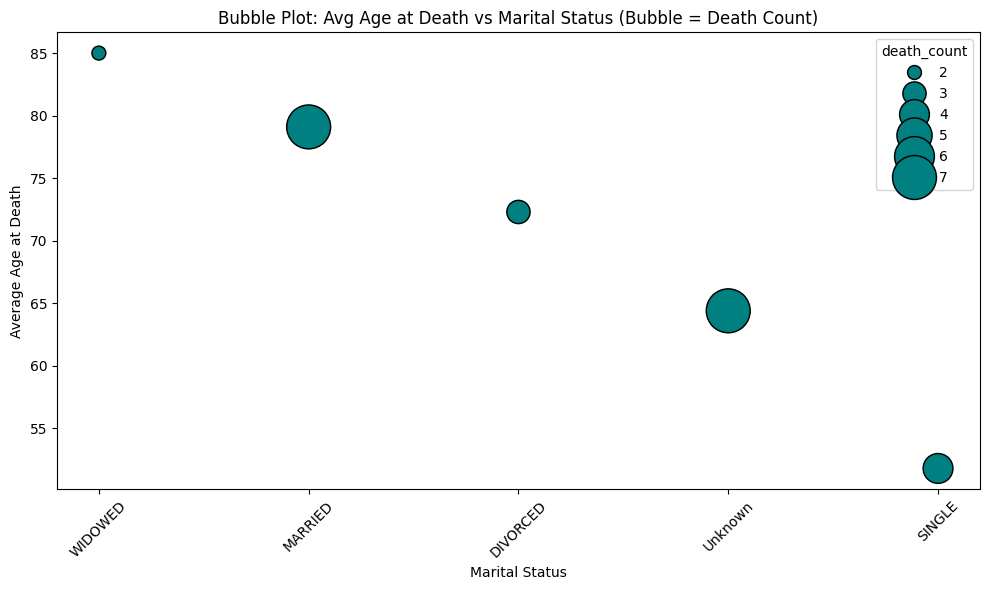

In [24]:
# Early Mortality with in 7 days of admission​ (Bubble Plot)​
#import seaborn as sns

# Convert DataFrame to dictionary with lists as values
dict_stats = early_mortality_df.to_dict(orient='list')

# Bubble Plot: Death count (size), average age (y), marital status (x)
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=dict_stats,
    x='marital_status_cleaned',
    y='avg_age_at_death',
    size='death_count',
    legend='brief',
    sizes=(100, 1000),
    color='teal',
    edgecolor='black'
)
plt.title('Bubble Plot: Avg Age at Death vs Marital Status (Bubble = Death Count)')
plt.xlabel('Marital Status')
plt.ylabel('Average Age at Death')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [96]:
# Steps to Load CSV from Google Drive in Google Colab
# df_4019_radiology_notes.csv' is a pre conditined csv files with ICD9 code 4019, which is "Hypertension"
# and we have filtered for "Radiology" events
from google.colab import auth, drive, files

drive.mount('/content/drive')
auth.authenticate_user()

df_copy = pd.read_csv('/content/drive/My Drive/df_4019_radiology_notes.csv')
print(df_copy.head(3))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   ROW_ID  SUBJECT_ID   HADM_ID   CHARTDATE            CHARTTIME  STORETIME  \
0  738405       93207  104110.0  2166-10-09  2166-10-09 20:24:00        NaN   
1  738661       24552       NaN  2153-01-12  2153-01-12 22:03:00        NaN   
2  738662       10390       NaN  2145-03-13  2145-03-13 02:58:00        NaN   

    CATEGORY                  DESCRIPTION  CGID  ISERROR  \
0  Radiology  DISTINCT PROCEDURAL SERVICE   NaN      NaN   
1  Radiology          CHEST (PORTABLE AP)   NaN      NaN   
2  Radiology         CT PELVIS W/CONTRAST   NaN      NaN   

                                                TEXT  
0  [**Last Name (LF) **],[**First Name3 (LF) **] ...  
1  [**2153-1-12**] 10:03 PM\n CHEST (PORTABLE AP)...  
2  [**2145-3-13**] 2:58 AM\n CT ABDOMEN W/CONTRAS...  


In [61]:
# cleans and tokenize
# import spacy
# import re
# import string
# from collections import Counter

# import pandas as pd
# import numpy as np

# from spacy.pipeline import EntityRuler
# from spacy.tokens import DocBin

nlp = spacy.load("en_core_web_sm")  # Use medSpaCy model here if installed
stop_words = nlp.Defaults.stop_words

def clean_and_tokenize(text,
                       lowercase=True,
                       remove_stopwords=True,
                       remove_punctuation=True,
                       min_token_len=2):

    if lowercase:
        text = text.lower()

    doc = nlp(text)

    tokens = []
    for token in doc:
        if remove_stopwords and token.text in stop_words:
            continue
        if remove_punctuation and token.text in string.punctuation:
            continue
        if len(token.text) < min_token_len:
            continue
        if token.is_space or token.is_digit:
            continue
        tokens.append(token.lemma_.strip())

    return " ".join(tokens)

In [35]:
df_copy['cleaned_tokens'] = df_copy["TEXT"].apply(lambda text: clean_and_tokenize(text))

In [37]:
# from spacy import displacy

nlp = spacy.load("en_core_web_sm")
# Loop through first 3 processed notes and render entities
for i in range(10):
    text = df_copy['cleaned_tokens'][i]
    doc = nlp(text)
    displacy.render(doc, style="ent", jupyter=True)
    print("*************************")

*************************


*************************


*************************


*************************


*************************


*************************


*************************


*************************


*************************


*************************


In [98]:
# Top most frequent diagnoses (by short title) grouped by marital status.

query_early_critical = """
SELECT
  CASE
    WHEN adm.marital_status IS NULL
         OR adm.marital_status IN ('UNKNOWN (DEFAULT)', 'None', '')
      THEN 'Unknown'
    ELSE adm.marital_status
  END AS marital_status_cleaned,
  dd.short_title AS diagnosis_name,
  COUNT(*) AS diagnosis_count
FROM
  `physionet-data.mimiciii_demo.admissions` AS adm
JOIN
  `physionet-data.mimiciii_demo.diagnoses_icd` AS d
  ON adm.hadm_id = d.hadm_id
JOIN
  `physionet-data.mimiciii_demo.d_icd_diagnoses` AS dd
  ON d.icd9_code = dd.icd9_code
WHERE
  dd.short_title IS NOT NULL
GROUP BY
  marital_status_cleaned, diagnosis_name
ORDER BY
  marital_status_cleaned, diagnosis_count DESC
LIMIT 10000;
"""

query_early_critical_df = run_bq_query(query_early_critical)

In [99]:
query_early_critical_df = run_bq_query(query_early_critical)


Query executed successfully! Data loaded into pandas DataFrame.
First 5 rows of the data:
  marital_status_cleaned           diagnosis_name  diagnosis_count
0               DIVORCED         Hypertension NOS                4
1               DIVORCED      Atrial fibrillation                3
2               DIVORCED                  CHF NOS                2
3               DIVORCED       Hypothyroidism NOS                2
4               DIVORCED  Ac posthemorrhag anemia                2


In [100]:
# Assign Critical Rating

# Assign critical rating based on frequency rank within each marital group
query_early_critical_df['critical_rating'] = query_early_critical_df.groupby('marital_status_cleaned')['diagnosis_count'] \
                                              .transform(lambda x: pd.qcut(x.rank(method='first'), 5, labels=[1, 2, 3, 4, 5])

# Preview
query_early_critical_df.head(1000)


,marital_status_cleaned,diagnosis_name,diagnosis_count,critical_rating
0,DIVORCED,Hypertension NOS,4,5
1,DIVORCED,Atrial fibrillation,3,5
2,DIVORCED,CHF NOS,2,5
3,DIVORCED,Hypothyroidism NOS,2,5
4,DIVORCED,Ac posthemorrhag anemia,2,5
...,...,...,...,...
891,WIDOWED,Hemorrhage complic proc,1,4
892,WIDOWED,Fall from slipping NEC,1,4
893,WIDOWED,Hypothyroidism NOS,1,4
894,WIDOWED,Ac DVT/embl low ext NOS,1,4


from matplotlib import pyplot as plt
_df_5['diagnosis_count'].plot(kind='hist', bins=20, title='diagnosis_count')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_6.groupby('marital_status_cleaned').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7['diagnosis_count'].plot(kind='line', figsize=(8, 4), title='diagnosis_count')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_8['marital_status_cleaned'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_8, x='diagnosis_count', y='marital_status_cleaned', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
_df_9['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_10['diagnosis_count'].plot(kind='hist', bins=20, title='diagnosis_count')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_11.groupby('marital_status_cleaned').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_12.plot(kind='scatter', x='index', y='diagnosis_count', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['diagnosis_count']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_13.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('marital_status_cleaned')):
  _plot_series(series, series_name, i)
  fig.legend(title='marital_status_cleaned', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('diagnosis_count')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_14.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('marital_status_cleaned')):
  _plot_series(series, series_name, i)
  fig.legend(title='marital_status_cleaned', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_15['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['diagnosis_count'].plot(kind='line', figsize=(8, 4), title='diagnosis_count')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['marital_status_cleaned'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='index', y='marital_status_cleaned', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_18['marital_status_cleaned'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_18, x='diagnosis_count', y='marital_status_cleaned', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

/tmp/ipython-input-108-72477812.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




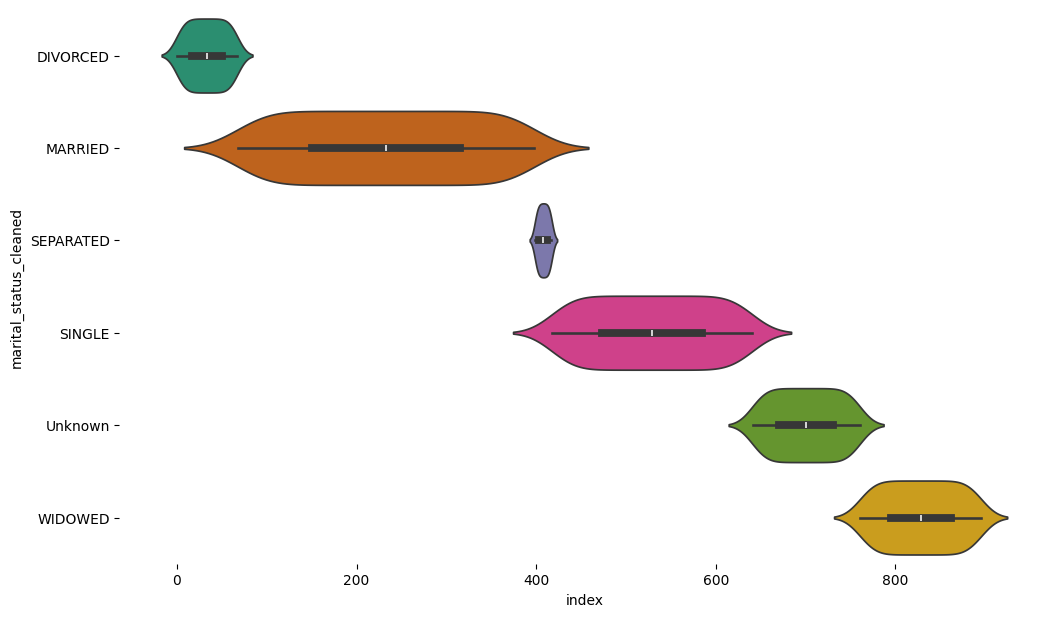

In [108]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['marital_status_cleaned'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='index', y='marital_status_cleaned', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

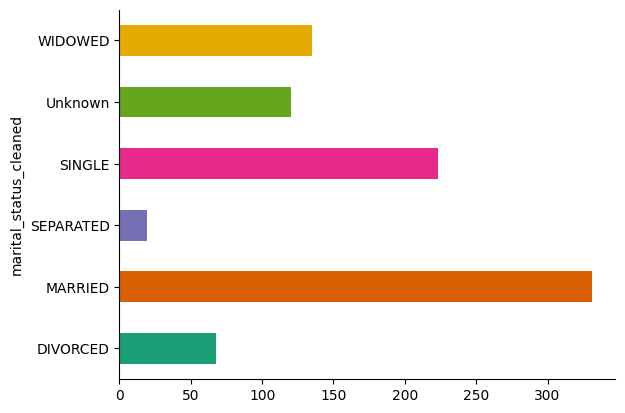

In [107]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_11.groupby('marital_status_cleaned').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [103]:
import plotly.express as px

fig = px.scatter(
    query_early_critical_df,
    x='marital_status_cleaned',
    y='diagnosis_name',
    size='diagnosis_count',
    color='critical_rating',
    color_continuous_scale='Reds',
    title='Critical Diagnoses per Marital Status',
    hover_data=['diagnosis_name', 'diagnosis_count', 'critical_rating']
)
fig.update_layout(height=800)
fig.show()


In [104]:
query_early_critical_df['cleaned_tokens'] = query_early_critical_df["diagnosis_name"].apply(lambda text: clean_and_tokenize(text))

In [109]:

query_early_critical_df['cleaned_tokens'] = query_early_critical_df["diagnosis_name"].apply(lambda text: clean_and_tokenize(text))

nlp = spacy.load("en_core_web_sm")
# Loop through first 3 processed notes and render entities
for i in range(100):
    text = query_early_critical_df['cleaned_tokens'][i]
    doc = nlp(text)
    displacy.render(doc, style="ent", jupyter=True)
    # print("*************************")

/usr/local/lib/python3.11/dist-packages/spacy/displacy/__init__.py:213: UserWarning:

[W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.

